In [77]:
import pandas as pd

df_raw_data = pd.read_csv("cleaned_merged_seasons.csv", encoding='ISO-8859-1')
df_raw_data.head()


/var/folders/2l/pn3snqhs29xcmtpz32whbh2w0000gn/T/ipykernel_89605/1640168381.py:3: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df_raw_data = pd.read_csv("cleaned_merged_seasons.csv", encoding='ISO-8859-1')


,Unnamed: 0,season_x,name,position,team_x,assists,bonus,bps,clean_sheets,creativity,...,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,GW
0,0,2016-17,Aaron Cresswell,DEF,NaN,0,0,0,0,0.0,...,2.0,0.0,0,0,0,0,55,False,0,1
1,1,2016-17,Aaron Lennon,MID,NaN,0,0,6,0,0.3,...,1.0,0.0,1,0,0,0,60,True,0,1
2,2,2016-17,Aaron Ramsey,MID,NaN,0,0,5,0,4.9,...,3.0,23.0,2,0,0,0,80,True,0,1
3,3,2016-17,Abdoulaye DoucourÃ©,MID,NaN,0,0,0,0,0.0,...,1.0,0.0,0,0,0,0,50,False,0,1
4,4,2016-17,Adam Forshaw,MID,NaN,0,0,3,0,1.3,...,1.0,0.0,1,0,0,0,45,True,1,1


In [78]:
import hashlib

def generate_player_id(name):
    return hashlib.md5(name.encode()).hexdigest()

df_raw_data['player_id'] = df_raw_data['name'].apply(generate_player_id)


In [79]:
def calculate_fpl_points(row):
    points = 0
    # For minutes played
    if row['minutes'] < 60:
        points += row['minutes'] * 1/60  # if less than 60 mins, pro-rata the points
    else:
        points += 2

    # For goals scored
    if row['position'] in ['Goalkeeper', 'Defender']:
        points += row['goals_scored'] * 6
    elif row['position'] == 'Midfielder':
        points += row['goals_scored'] * 5
    else:  # Forward
        points += row['goals_scored'] * 4

    # For assists
    points += row['assists'] * 3

    # For clean sheets
    if row['position'] in ['Goalkeeper', 'Defender']:
        points += row['clean_sheets'] * 4
    elif row['position'] == 'Midfielder':
        points += row['clean_sheets'] * 1

    # For saves by a goalkeeper
    if row['position'] == 'Goalkeeper':
        points += row['saves'] // 3  # 1 point for every 3 saves

    # For penalty saves by a goalkeeper
    if row['position'] == 'Goalkeeper':
        points += row['penalties_saved'] * 5

    # For penalty misses
    points -= row['penalties_missed'] * 2

    # For yellow and red cards
    points -= row['yellow_cards']
    points -= row['red_cards'] * 3

    # For own goals
    points -= row['own_goals'] * 2

    # For goals conceded by goalkeeper or defender
    if row['position'] in ['Goalkeeper', 'Defender']:
        points -= (row['goals_conceded'] // 2)  # -1 point for every 2 goals conceded

    return points

# Apply the function to each row and create a new column
df_raw_data['fpl_points'] = df_raw_data.apply(calculate_fpl_points, axis=1)


In [80]:
def first_non_nan(series):
    return series.dropna().iloc[0] if not series.dropna().empty else None


In [81]:
agg_dict = {
    'player_id': 'first',
    'team_x': first_non_nan,
    'assists': 'sum',
    'bonus': 'sum',
    'bps': 'sum',
    'clean_sheets': 'sum',
    'creativity': 'sum',
    'element': 'sum',
    'goals_conceded': 'sum',
    'goals_scored': 'sum',
    'influence': 'sum',
    'minutes': 'sum',
    'own_goals': 'sum',
    'red_cards': 'sum',
    'yellow_cards': 'sum',
    'fixture': 'max',
    'ict_index': 'mean',
    'fpl_points': 'sum'
}

player_season_totals = df_raw_data.groupby(['name', 'season_x']).agg(agg_dict).reset_index()

# If you'd like to rename the columns
player_season_totals.rename(columns={'ict_index': 'average_ict_index'}, inplace=True)

# This will give you a dataframe with aggregated statistics for each player for each season.



In [82]:
#Sort the dataframe
player_season_totals_sorted = player_season_totals.sort_values(by=['name', 'player_id', 'season_x']).reset_index(drop=True)

#Initialize a new column for the points of the next season with NaN values
player_season_totals_sorted['points_next_season'] = None

#Loop through the dataframe
for i in range(len(player_season_totals_sorted) - 1):  # Use the correct dataframe in the range
    # Check if the next row's player ID matches the current row's player ID
    if player_season_totals_sorted.loc[i, 'player_id'] == player_season_totals_sorted.loc[i+1, 'player_id']:
        player_season_totals_sorted.loc[i, 'points_next_season'] = player_season_totals_sorted.loc[i+1, 'fpl_points']  # Fixed 'v' to 'player_season_totals_sorted'

# Convert the new column to float (because it was initialized with None values)
player_season_totals_sorted['points_next_season'] = player_season_totals_sorted['points_next_season'].astype(float)

# Filtering rows where season_x is not '2021-22'
player_season_totals_sorted = player_season_totals_sorted[player_season_totals_sorted['season_x'] != '2021-22']



In [83]:
player_season_totals_sorted.head()

,name,season_x,player_id,team_x,assists,bonus,bps,clean_sheets,creativity,element,...,goals_scored,influence,minutes,own_goals,red_cards,yellow_cards,fixture,average_ict_index,fpl_points,points_next_season
0,Aaron Connolly,2019-20,afeaaf69bb3a5088e4a666484141db1d,None,3,5,146,5,91.4,18690,...,3,150.6,1250,0,0,0,372,2.171429,49.600000,30.666667
1,Aaron Connolly,2020-21,afeaaf69bb3a5088e4a666484141db1d,Brighton,1,2,95,1,74.1,2964,...,2,104.2,783,0,0,0,369,1.268421,30.666667,3.566667
3,Aaron Cresswell,2016-17,af4648e7b4da37566e87e35b6e002d7b,None,2,1,334,5,284.7,17252,...,0,307.6,2115,0,1,2,372,1.873684,48.700000,86.900000
4,Aaron Cresswell,2017-18,af4648e7b4da37566e87e35b6e002d7b,None,7,10,613,10,562.7,16834,...,1,690.2,3069,0,0,7,380,3.815789,86.900000,36.466667
5,Aaron Cresswell,2018-19,af4648e7b4da37566e87e35b6e002d7b,None,1,0,257,1,290.9,15276,...,0,318.2,1588,0,0,1,380,1.902632,36.466667,65.833333


In [85]:
#Data Preparation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Drop rows where the 'points_next_season' is NaN
player_season_totals_sorted = player_season_totals_sorted.dropna(subset=['points_next_season'])

# Features (Drop non-numerical columns and target column)
X = player_season_totals_sorted.drop(columns=['name', 'player_id', 'season_x', 'points_next_season'])

# Target
y = player_season_totals_sorted['points_next_season']

# Splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 2. Model Selection
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Train model
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Predictions
y_pred = model.predict(X_test_scaled)

# Evaluate model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")


Mean Squared Error: 727.5179583276713


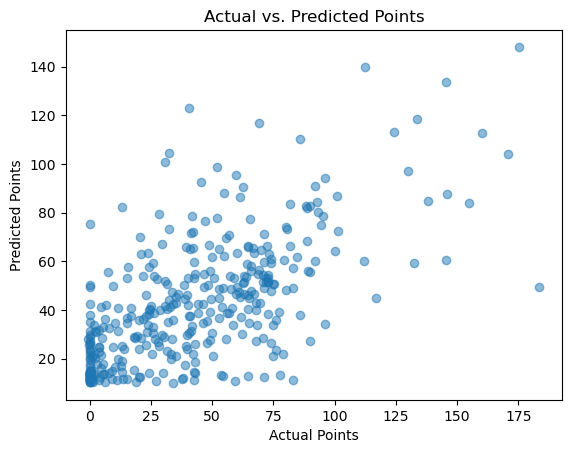

In [86]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual Points")
plt.ylabel("Predicted Points")
plt.title("Actual vs. Predicted Points")
plt.show()


In [90]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Assuming player_season_totals_sorted is your dataframe
X = player_season_totals_sorted.drop(['name', 'player_id', 'team_x', 'season_x', 'points_next_season'], axis=1) # Dropping non-numeric columns
y = player_season_totals_sorted['points_next_season']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rfr = RandomForestRegressor(n_estimators=100, random_state=42)
rfr.fit(X_train, y_train)

y_pred = rfr.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error using Random Forest: {mse}")

Mean Squared Error using Random Forest: 766.4822826219385


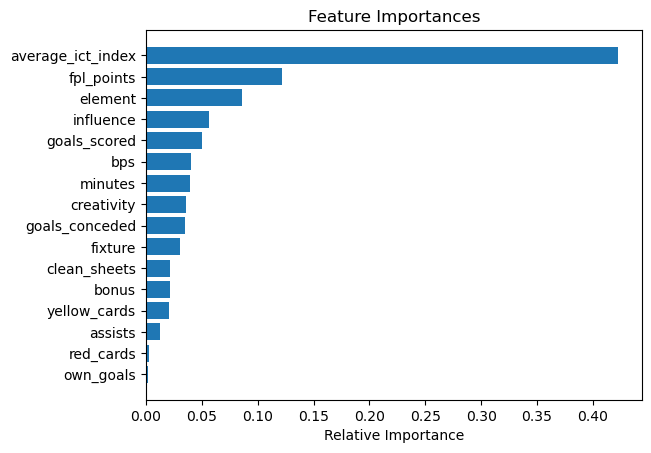

In [91]:
import numpy as np

importances = rfr.feature_importances_
features = X_train.columns
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()


In [93]:
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor

# Preparing the data
# Drop rows with NaN values in 'points_next_season' column
data = player_season_totals_sorted.dropna(subset=['points_next_season'])

# Defining features (excluding name, player_id, season_x, and points_next_season)
X = data.drop(['name', 'player_id', 'team_x', 'season_x', 'points_next_season'], axis=1)
y = data['points_next_season']

# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Defining the model
model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Training the model
model.fit(X_train, y_train)

# Predicting using the model
y_pred = model.predict(X_test)

# Calculating Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 731.9120022295424


In [94]:
from sklearn.model_selection import GridSearchCV

# Define the set of hyperparameters you want to tune
param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'learning_rate': [0.001, 0.01, 0.1, 0.5],
    'max_depth': [3, 4, 5, 6],
    'subsample': [0.8, 0.9, 1.0], # fraction of samples used for fitting the trees
    'max_features': ['sqrt', 'log2', None] # number of features to consider when looking for the best split
}

# Create a GradientBoostingRegressor object
gbr = GradientBoostingRegressor(random_state=42)

# Use GridSearchCV with the estimator and parameter grid
grid_search = GridSearchCV(gbr, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)

# Fit the model to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters from the grid search
best_params = grid_search.best_params_

# Use the best estimator from the grid search to make predictions
best_gbr = grid_search.best_estimator_
y_pred = best_gbr.predict(X_test)

# Calculate and print the MSE
mse = mean_squared_error(y_test, y_pred)
print(f"Best MSE after Grid Search: {mse}")
print(f"Best Parameters: {best_params}")


Fitting 5 folds for each of 576 candidates, totalling 2880 fits
[CV] END learning_rate=0.001, max_depth=3, max_features=sqrt, n_estimators=50, subsample=0.9; total time=   0.1s
[CV] END learning_rate=0.001, max_depth=3, max_features=sqrt, n_estimators=50, subsample=1.0; total time=   0.0s
[CV] END learning_rate=0.001, max_depth=3, max_features=sqrt, n_estimators=100, subsample=0.9; total time=   0.1s
[CV] END learning_rate=0.001, max_depth=3, max_features=sqrt, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.001, max_depth=3, max_features=sqrt, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.001, max_depth=3, max_features=sqrt, n_estimators=300, subsample=0.9; total time=   0.3s
[CV] END learning_rate=0.001, max_depth=3, max_features=log2, n_estimators=50, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.001, max_depth=3, max_features=log2, n_estimators=50, subsample=0.9; total time=   0.1s
[CV] END learning_rate=0.001

[CV] END learning_rate=0.001, max_depth=3, max_features=sqrt, n_estimators=50, subsample=0.8; total time=   0.0s
[CV] END learning_rate=0.001, max_depth=3, max_features=sqrt, n_estimators=50, subsample=1.0; total time=   0.0s
[CV] END learning_rate=0.001, max_depth=3, max_features=sqrt, n_estimators=100, subsample=0.9; total time=   0.1s
[CV] END learning_rate=0.001, max_depth=3, max_features=sqrt, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.001, max_depth=3, max_features=sqrt, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.001, max_depth=3, max_features=sqrt, n_estimators=300, subsample=0.9; total time=   0.3s
[CV] END learning_rate=0.001, max_depth=3, max_features=log2, n_estimators=50, subsample=0.8; total time=   0.0s
[CV] END learning_rate=0.001, max_depth=3, max_features=log2, n_estimators=50, subsample=0.9; total time=   0.0s
[CV] END learning_rate=0.001, max_depth=3, max_features=log2, n_estimators=50, subsample=1.0

[CV] END learning_rate=0.001, max_depth=4, max_features=sqrt, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.001, max_depth=4, max_features=sqrt, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.001, max_depth=4, max_features=sqrt, n_estimators=200, subsample=0.9; total time=   0.2s
[CV] END learning_rate=0.001, max_depth=4, max_features=sqrt, n_estimators=300, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.001, max_depth=4, max_features=sqrt, n_estimators=300, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.001, max_depth=4, max_features=log2, n_estimators=100, subsample=0.9; total time=   0.1s
[CV] END learning_rate=0.001, max_depth=4, max_features=log2, n_estimators=100, subsample=0.9; total time=   0.1s
[CV] END learning_rate=0.001, max_depth=4, max_features=log2, n_estimators=200, subsample=0.9; total time=   0.2s
[CV] END learning_rate=0.001, max_depth=4, max_features=log2, n_estimators=200, subsampl

[CV] END learning_rate=0.001, max_depth=3, max_features=sqrt, n_estimators=50, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.001, max_depth=3, max_features=sqrt, n_estimators=50, subsample=1.0; total time=   0.0s
[CV] END learning_rate=0.001, max_depth=3, max_features=sqrt, n_estimators=100, subsample=0.9; total time=   0.1s
[CV] END learning_rate=0.001, max_depth=3, max_features=sqrt, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.001, max_depth=3, max_features=sqrt, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.001, max_depth=3, max_features=sqrt, n_estimators=300, subsample=0.9; total time=   0.3s
[CV] END learning_rate=0.001, max_depth=3, max_features=log2, n_estimators=50, subsample=0.8; total time=   0.0s
[CV] END learning_rate=0.001, max_depth=3, max_features=log2, n_estimators=50, subsample=0.9; total time=   0.1s
[CV] END learning_rate=0.001, max_depth=3, max_features=log2, n_estimators=50, subsample=1.0

[CV] END learning_rate=0.01, max_depth=6, max_features=sqrt, n_estimators=200, subsample=0.9; total time=   0.3s
[CV] END learning_rate=0.01, max_depth=6, max_features=sqrt, n_estimators=300, subsample=0.8; total time=   0.5s
[CV] END learning_rate=0.01, max_depth=6, max_features=sqrt, n_estimators=300, subsample=1.0; total time=   0.5s
[CV] END learning_rate=0.01, max_depth=6, max_features=log2, n_estimators=50, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=6, max_features=log2, n_estimators=100, subsample=0.9; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=6, max_features=log2, n_estimators=200, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.01, max_depth=6, max_features=log2, n_estimators=200, subsample=1.0; total time=   0.4s
[CV] END learning_rate=0.01, max_depth=6, max_features=log2, n_estimators=300, subsample=0.9; total time=   0.7s
[CV] END learning_rate=0.01, max_depth=6, max_features=None, n_estimators=50, subsample=0.8; tota

[CV] END learning_rate=0.001, max_depth=4, max_features=sqrt, n_estimators=100, subsample=0.9; total time=   0.1s
[CV] END learning_rate=0.001, max_depth=4, max_features=sqrt, n_estimators=100, subsample=0.9; total time=   0.1s
[CV] END learning_rate=0.001, max_depth=4, max_features=sqrt, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.001, max_depth=4, max_features=sqrt, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.001, max_depth=4, max_features=sqrt, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.001, max_depth=4, max_features=sqrt, n_estimators=300, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.001, max_depth=4, max_features=log2, n_estimators=50, subsample=0.9; total time=   0.1s
[CV] END learning_rate=0.001, max_depth=4, max_features=log2, n_estimators=50, subsample=0.9; total time=   0.1s
[CV] END learning_rate=0.001, max_depth=4, max_features=log2, n_estimators=100, subsample=

[CV] END learning_rate=0.001, max_depth=4, max_features=None, n_estimators=100, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.001, max_depth=4, max_features=None, n_estimators=300, subsample=0.8; total time=   0.9s
[CV] END learning_rate=0.001, max_depth=4, max_features=None, n_estimators=300, subsample=0.8; total time=   0.9s
[CV] END learning_rate=0.001, max_depth=5, max_features=sqrt, n_estimators=100, subsample=0.9; total time=   0.1s
[CV] END learning_rate=0.001, max_depth=5, max_features=sqrt, n_estimators=100, subsample=0.9; total time=   0.1s
[CV] END learning_rate=0.001, max_depth=5, max_features=sqrt, n_estimators=200, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.001, max_depth=5, max_features=sqrt, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.001, max_depth=5, max_features=sqrt, n_estimators=200, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.001, max_depth=5, max_features=sqrt, n_estimators=300, subsampl

[CV] END learning_rate=0.001, max_depth=3, max_features=sqrt, n_estimators=50, subsample=0.9; total time=   0.0s
[CV] END learning_rate=0.001, max_depth=3, max_features=sqrt, n_estimators=50, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.001, max_depth=3, max_features=sqrt, n_estimators=100, subsample=0.9; total time=   0.1s
[CV] END learning_rate=0.001, max_depth=3, max_features=sqrt, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.001, max_depth=3, max_features=sqrt, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.001, max_depth=3, max_features=sqrt, n_estimators=300, subsample=0.9; total time=   0.3s
[CV] END learning_rate=0.001, max_depth=3, max_features=log2, n_estimators=50, subsample=0.8; total time=   0.0s
[CV] END learning_rate=0.001, max_depth=3, max_features=log2, n_estimators=50, subsample=0.9; total time=   0.1s
[CV] END learning_rate=0.001, max_depth=3, max_features=log2, n_estimators=100, subsample=0.

[CV] END learning_rate=0.01, max_depth=4, max_features=log2, n_estimators=50, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=4, max_features=log2, n_estimators=100, subsample=0.9; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=4, max_features=log2, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=4, max_features=log2, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=4, max_features=log2, n_estimators=300, subsample=0.9; total time=   0.3s
[CV] END learning_rate=0.01, max_depth=4, max_features=None, n_estimators=50, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=4, max_features=None, n_estimators=50, subsample=0.9; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=4, max_features=None, n_estimators=100, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.01, max_depth=4, max_features=None, n_estimators=100, subsample=1.0; total

Best MSE after Grid Search: 720.4873690379192
Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'max_features': 'sqrt', 'n_estimators': 50, 'subsample': 0.8}
